# Exploring Dynamic Time Based TCP Congestion Control (DTBC)


Let's mimic real world congestion patterns that vary bu time of day. We will adjust our Alpha and Beta dynamically over time by simulating a clock to represent time of the day
During High Traffic hours, we will reduce alpha and increase beta
During Low Traffic hours, we will increase alpha and decrease beta

## 1. Initialisation

### 1.1) Simulating values

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed (for now) 24-hour traffic load
hourly_load = {
    0: 0.5,  1: 0.5,  2: 0.4,  3: 0.4,  4: 0.4,  5: 0.4,
    6: 0.5,  7: 0.6,  8: 0.7,  9: 0.9, 10: 1.0, 11: 1.0,
    12: 1.2, 13: 1.3, 14: 1.3, 15: 1.3, 16: 1.2, 17: 1.1,
    18: 1.0, 19: 0.9, 20: 0.8, 21: 0.7, 22: 0.5, 23: 0.5
}
# Simulate maximum load
C = 50

# This represents network's estimated congestion level (every hour) in a day
# Used to adjust alpha and beta
predicted_demand_factors = np.zeros(24)
for i in range(24):
    predicted_demand_factors[i] = hourly_load[i]

### 1.2) Visualising Traffic demand variations

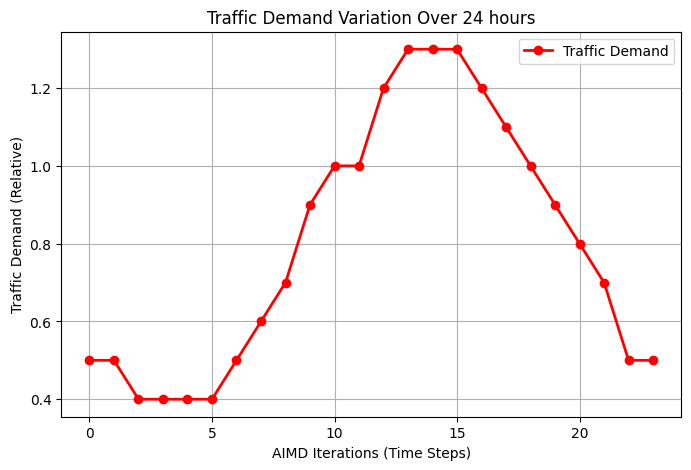

In [2]:
# Plot demand variation over iterations for 24 hours
plt.figure(figsize=(8, 5))
plt.plot(range(24), predicted_demand_factors, marker='o', linestyle='-', color='red', linewidth=2, label='Traffic Demand')
plt.xlabel('AIMD Iterations (Time Steps)')
plt.ylabel('Traffic Demand (Relative)')
plt.title('Traffic Demand Variation Over 24 hours')
plt.grid(True)
plt.legend()
plt.show()

### 1.3 Simulate user traffic 
Done over 100 hours for 2 different users


I've also assumed each have a different variation in demand, and slightly different average demand 

In [3]:
random_factor_1 = 0.1
random_factor_2 = 0.2
avg_demand_1 = C * 0.6 # 30/50
avg_demand_2 = C * 0.8 # 40/50
user_demand_1 = np.zeros(100)
user_demand_2 = np.zeros(100)

for i in range(100):
    # Map to correct hour (cycle repeats every 24 hours)
    hour = i % 24
    # Base demand on hourly load
    base_demand = avg_demand_1 * hourly_load[hour]
    # Introduce slight variation: ±10% randomness
    user_demand_1[i] = base_demand * (1 + np.random.uniform(-random_factor_1, random_factor_1))  # Slight randomness

for i in range(100):
    # Map to correct hour (cycle repeats every 24 hours)
    hour = i % 24
    # Base demand on hourly load
    base_demand = avg_demand_2 * hourly_load[hour]
    # Introduce slight variation: ±10/20% randomness
    user_demand_2[i] = base_demand * (1 + np.random.uniform(-random_factor_2, random_factor_2))  # Slight randomness


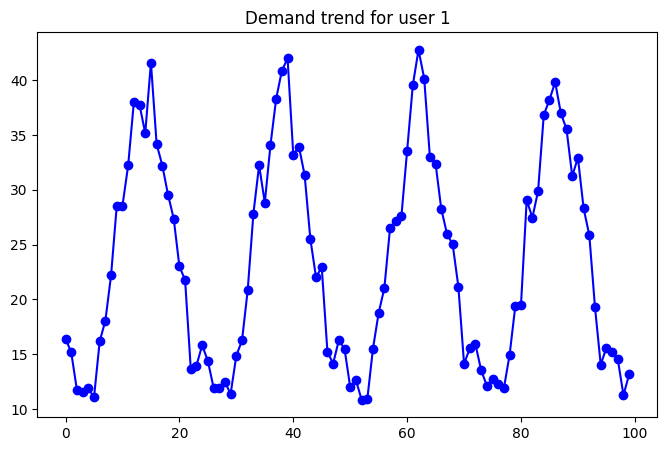

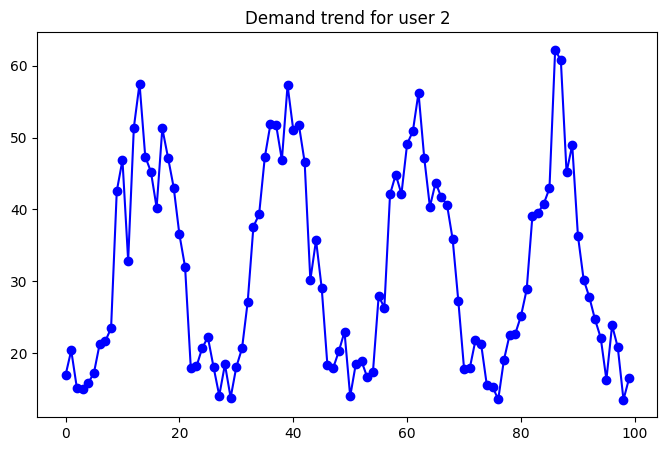

In [4]:
# Plot demand trends
plt.figure(figsize=(8, 5))
plt.title("Demand trend for user 1")
plt.plot(range(100), user_demand_1, marker='o', linestyle='-', color='blue', linewidth=1.5, label='User 1 Demand')

# Plot demand trends (user 2)
plt.figure(figsize=(8, 5))
plt.title("Demand trend for user 2")
plt.plot(range(100), user_demand_2, marker='o', linestyle='-', color='blue', linewidth=1.5, label='User 2 Demand')

### 1.4) Utility Functions

In [5]:
def convergencePlotUtil(C, x1_values, x2_values, title):
    """
    Plots the convergence of two users (x1 against x2) under AIMD-based congestion control.

    This function visualizes how the two flows evolve over iterations and whether they 
    reach a stable equilibrium in terms of bandwidth allocation. It overlays fairness 
    and efficiency lines to highlight convergence properties.

    Parameters:
    C (int): Maximum network capacity.
    x1_values (NP Array): Congestion window sizes of x1.
    x2_values (NP Array): Congestion window sizes of x2 .
    title (str): Title for the plot
    """
    plt.figure(figsize=(8, 6))
    plt.plot(x1_values, x2_values, 'black', marker='.', label='AIMD Iterations')

    # Set limits for x y axes
    plt.xlim(0, C * 1.1)
    plt.ylim(0, C * 1.1)

    # Plot Fairness Line (x1=x2)
    fairness_line_x_values = np.linspace(0, C*1.1, 100)
    plt.plot(fairness_line_x_values, fairness_line_x_values, 
            label='Fairness Line (x1 = x2)', linestyle='dashed', linewidth=1, color='blue')

    # Plot Efficiency Line (x1+x2==C)
    efficiency_line_x_values = np.linspace(0, C, 100)
    efficiency_line_y_values = C - efficiency_line_x_values
    plt.plot(efficiency_line_x_values, efficiency_line_y_values, 
            label='Efficiency Line (x1 + x2 = C)', linestyle='dashed', linewidth=1, color='red')

    # Define the optimal point (Intersection of both lines, ideally C/2, C/2)
    optimal_x = C / 2
    optimal_y = C / 2
    plt.plot(optimal_x, optimal_y, marker='o', markersize=8, color='green', 
            label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    plt.xlabel('x1')
    plt.ylabel('x2 ')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


def congestionPlotUtil(x1_values, x2_values, title):
    """
    Plots the congestion window for two users (x1 and x2) over iterations.

    This function visualizes how the congestion window size changes with time, helping
    to analyze how bandwidth is allocated dynamically in a network environment.

    Parameters:
    x1_values (NP Array): Congestion window sizes of x1.
    x2_values (NP Array): Congestion window sizes of x2.
    title (str): Title for the plot.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(x1_values)), x1_values, marker=".", color='blue', linewidth=1, label='x1 Congestion Window')
    plt.plot(range(len(x2_values)), x2_values, marker=".", color='red', linewidth=1, label='x2 Congestion Window')
    plt.xlabel('Iterations (RTTs)')
    plt.ylabel('Congestion Window Size')
    plt.grid(True, linestyle='--', linewidth=0.6)
    plt.legend()
    plt.title(title)
    plt.show()

## 2) AIMD Algorithm
Adapted and modified from Prof. Tan Chee Wei's Tutorial to fit my needs, and translated to py

In [6]:
def AIMD_algo(userDemand1, userDemand2, C, alpha, beta, total_hours=100, hourly_itr = 100):
    # 2D np matrix to store allocation
    x1_values_hourly = np.zeros((total_hours, hourly_itr))
    x2_values_hourly = np.zeros((total_hours, hourly_itr))

    for i in range(total_hours):
        # Get user demand for current hour
        x1 = userDemand1[i]
        x2 = userDemand2[i]

        for j in range(hourly_itr):
            # AI: Never exceed
            if x1 + x2 <= C: 
                x1 += alpha
                x2 += alpha
            # MD: Exceed; Congestion
            else: 
                x1 *= beta
                x2 *= beta

            # Store values
            x1_values_hourly[i][j] = x1
            x2_values_hourly[i][j] = x2

    # Plot results
    convergencePlotUtil(C, x1_values_hourly[5], x2_values_hourly[5], "AIMD h=5 (low traffic)")
    convergencePlotUtil(C, x1_values_hourly[10], x2_values_hourly[10], "AIMD h=9 (mid traffic)")
    convergencePlotUtil(C, x1_values_hourly[15], x2_values_hourly[15], "AIMD h=15 (peak traffic)")
        
    # Plot Congestion Window for x1
    congestionPlotUtil(x1_values_hourly[5], x2_values_hourly[5], "AIMD h=5 (low traffic) congestPlot")
    congestionPlotUtil(x1_values_hourly[10], x2_values_hourly[10], "AIMD h=10 (mid traffic) congestPlot")
    congestionPlotUtil(x1_values_hourly[15], x2_values_hourly[15], "AIMD h=15 (high traffic) congestPlot")


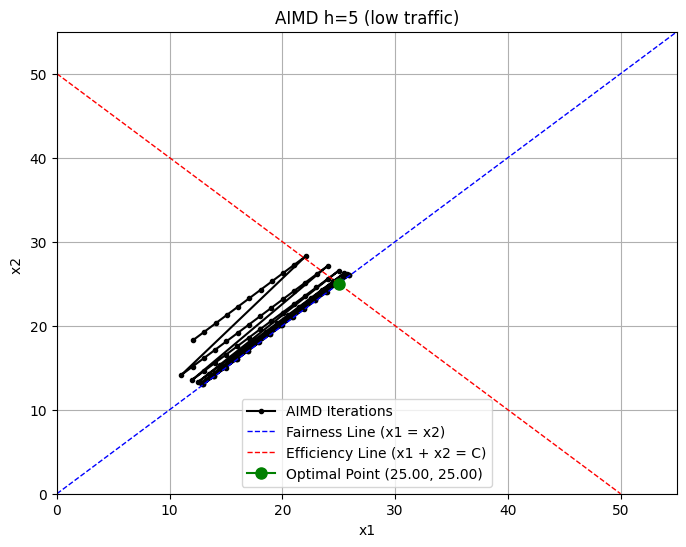

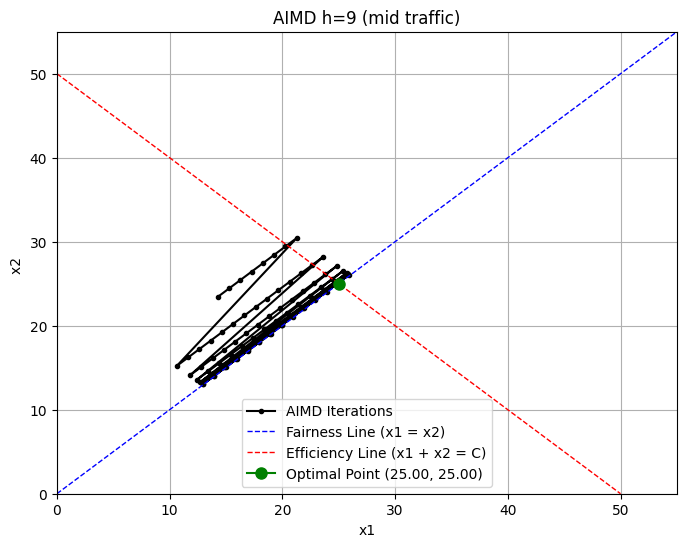

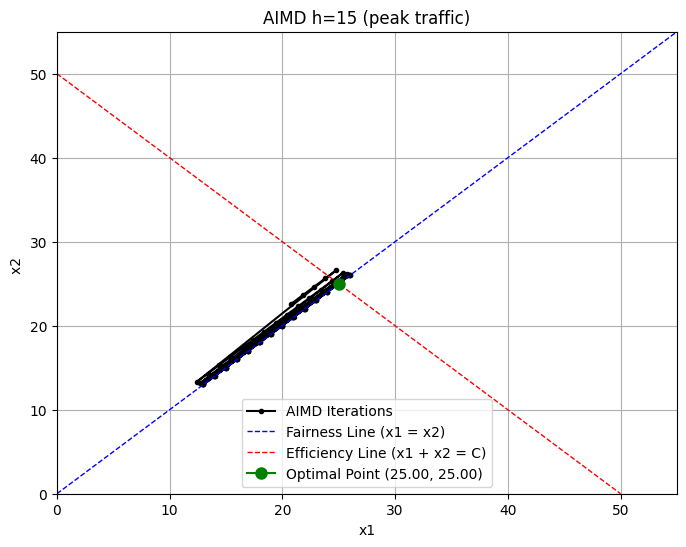

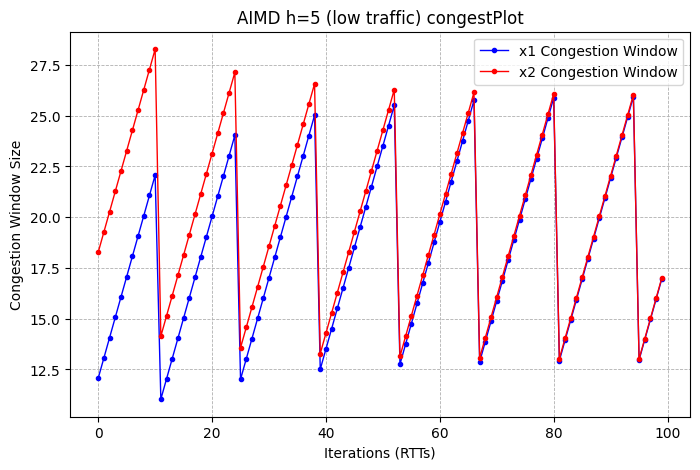

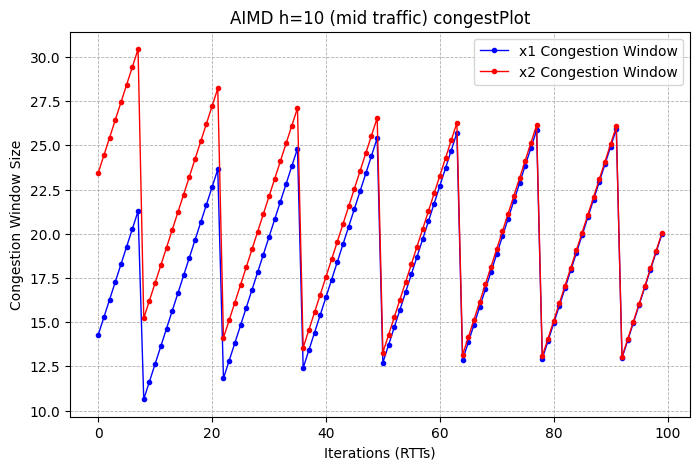

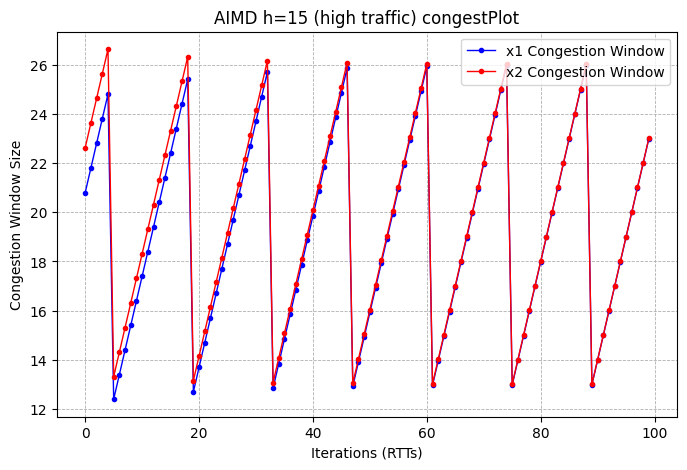

In [7]:
AIMD_algo(user_demand_1, user_demand_2, 50, 1, 0.5)

## 3) Dynamic Time Based congestion Control (DTBC)
Our new time based dynamic algiorhtm to control additive and decrease

In [8]:
def DTBC_algo(userDemand1, userDemand2, predictedDemandFactor, C, alpha, beta, total_hours=100, hourly_itr = 100):
    # 2D np matrix to store allocation
    x1_values_hourly = np.zeros((total_hours, hourly_itr))
    x2_values_hourly = np.zeros((total_hours, hourly_itr))
    print(predictedDemandFactor)
    # Keep original a/b values as we're scaling it every time itr
    originalAlpha = alpha # 1
    originalBeta = beta #0.5

    for i in range(total_hours):
        # Get user demand for current hour
        x1 = userDemand1[i]
        x2 = userDemand2[i]
        # Simulate time of day (0-23 hours repeating every 24 iterations)
        time_of_the_day= i % 24
        curPredictedDemandFactor = predictedDemandFactor[time_of_the_day]

        # Adjust AIMD parameters based on current predicted demand
        alpha = originalAlpha / curPredictedDemandFactor  # Higher demand → Higher increase rate; vice versa
        beta = 1 - ((1-originalBeta) * curPredictedDemandFactor)  # Lower demand → Smaller decrease rate; vice versa
        # a=1, b=0.5
        #print(f"t={time_of_the_day} a={alpha}, b={beta}")
        for j in range(hourly_itr):
            # Additive Increase
            if x1 + x2 <= C: 
                x1 += alpha 
                x2 += alpha 
            # Multiplicative Decrease 
            else: 
                x1 *= beta
                x2 *= beta
        
            # Store values
            x1_values_hourly[i][j] = x1
            x2_values_hourly[i][j] = x2
    # Plot results
    convergencePlotUtil(C, x1_values_hourly[5], x2_values_hourly[5], "DTBC h=5 (low traffic)")
    convergencePlotUtil(C, x1_values_hourly[10], x2_values_hourly[10], "DTBC h=9 (mid traffic)")
    convergencePlotUtil(C, x1_values_hourly[15], x2_values_hourly[15], "DTBC h=15 (peak traffic)")
        
    # Plot Congestion Window for x1
    congestionPlotUtil(x1_values_hourly[5], x2_values_hourly[5], "DTBC h=5 (low traffic) congestPlot")
    congestionPlotUtil(x1_values_hourly[10], x2_values_hourly[10], "DTBC h=10 (mid traffic) congestPlot")
    congestionPlotUtil(x1_values_hourly[15], x2_values_hourly[15], "DTBC h=15 (high traffic) congestPlot")


[0.5 0.5 0.4 0.4 0.4 0.4 0.5 0.6 0.7 0.9 1.  1.  1.2 1.3 1.3 1.3 1.2 1.1
 1.  0.9 0.8 0.7 0.5 0.5]


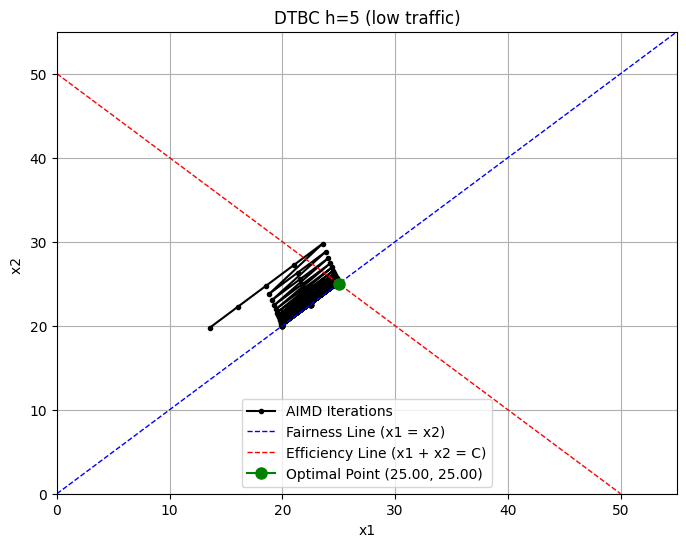

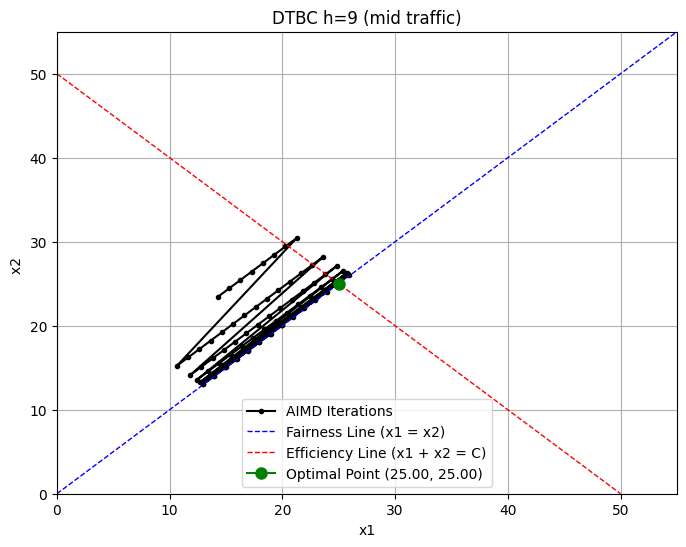

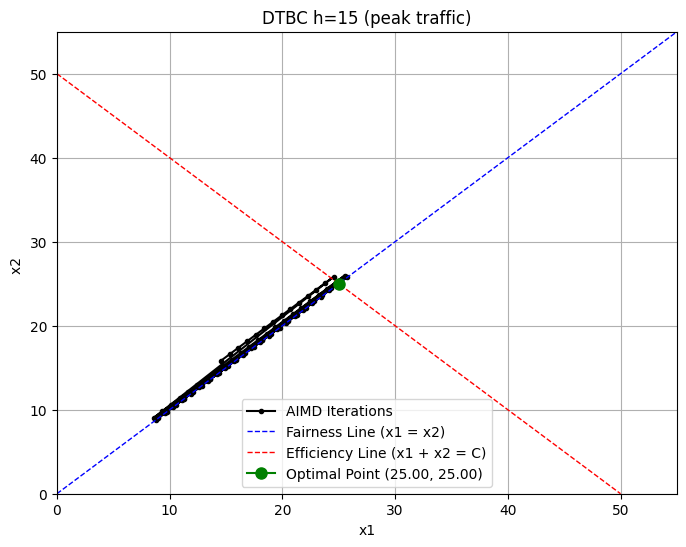

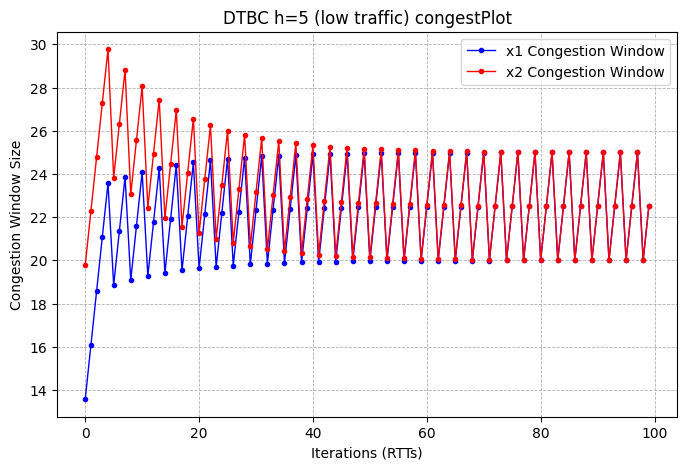

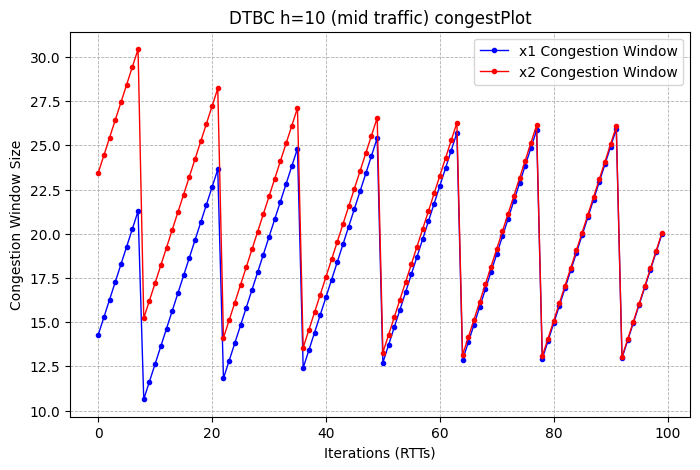

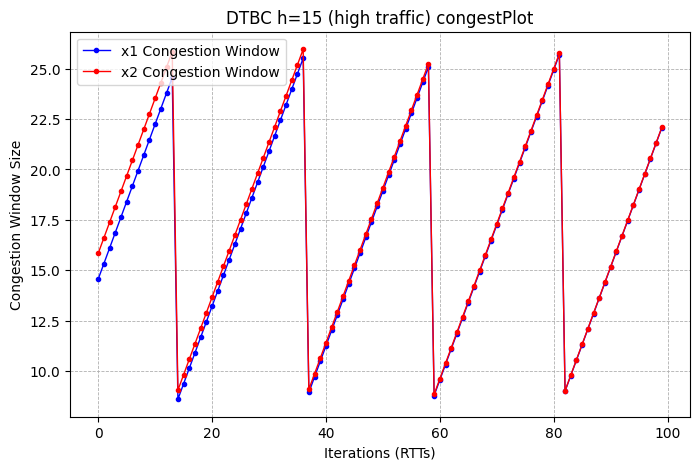

In [9]:
DTBC_algo(user_demand_1, user_demand_2, predicted_demand_factors, 50, 1, 0.5)